# Importing Packages

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
os.makedirs('test_dir', exist_ok=True)

In [ ]:

project_name = 'FER_2013_Emotion_Detection'

model_names = ['VGG16_Transfer_Learning']

base_dir = '/content/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning

In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

data_dir = '/content/train'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

# Data Analysis

In [ ]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))

    df = pd.DataFrame(counts, index=[set_name])
    return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  fear  happy  disgust  neutral  angry  surprise
train  4830  4097   7215      436     4965   3995      3171
       sad  fear  happy  disgust  neutral  angry  surprise
test  1247  1024   1774      111     1233    958       831


<Axes: >

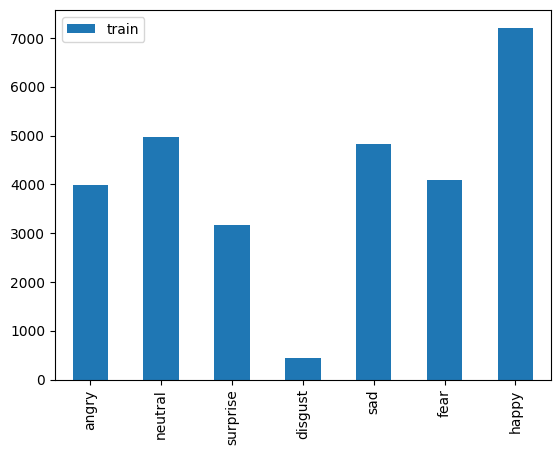

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

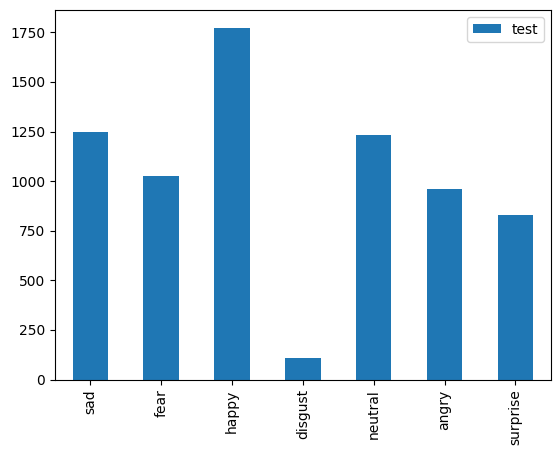

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

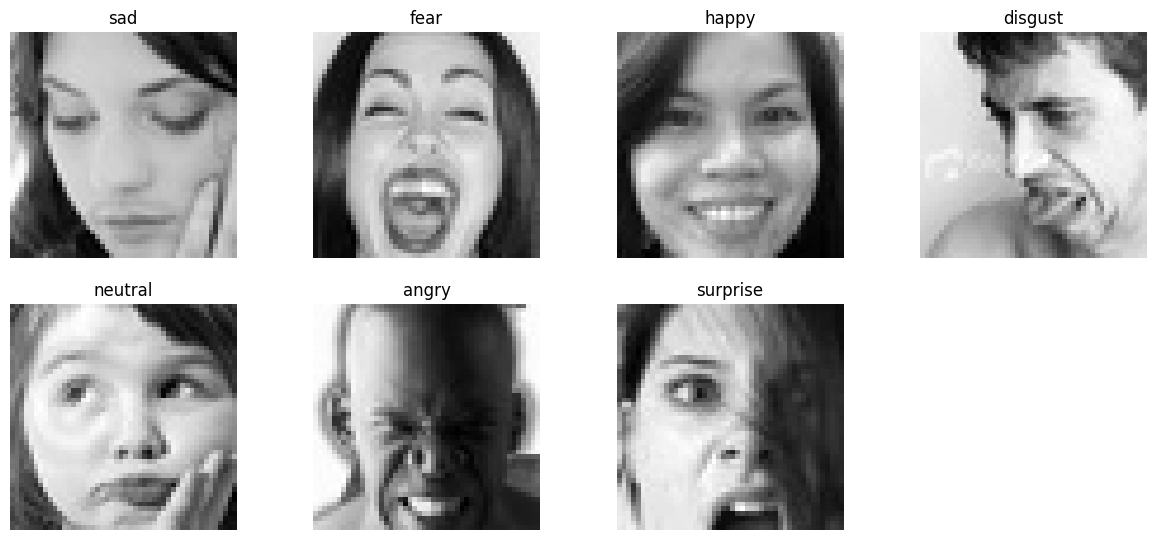

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) 
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    # print(img)
    print("Shape:", img.shape)  
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Transfer Learning with VGGNET

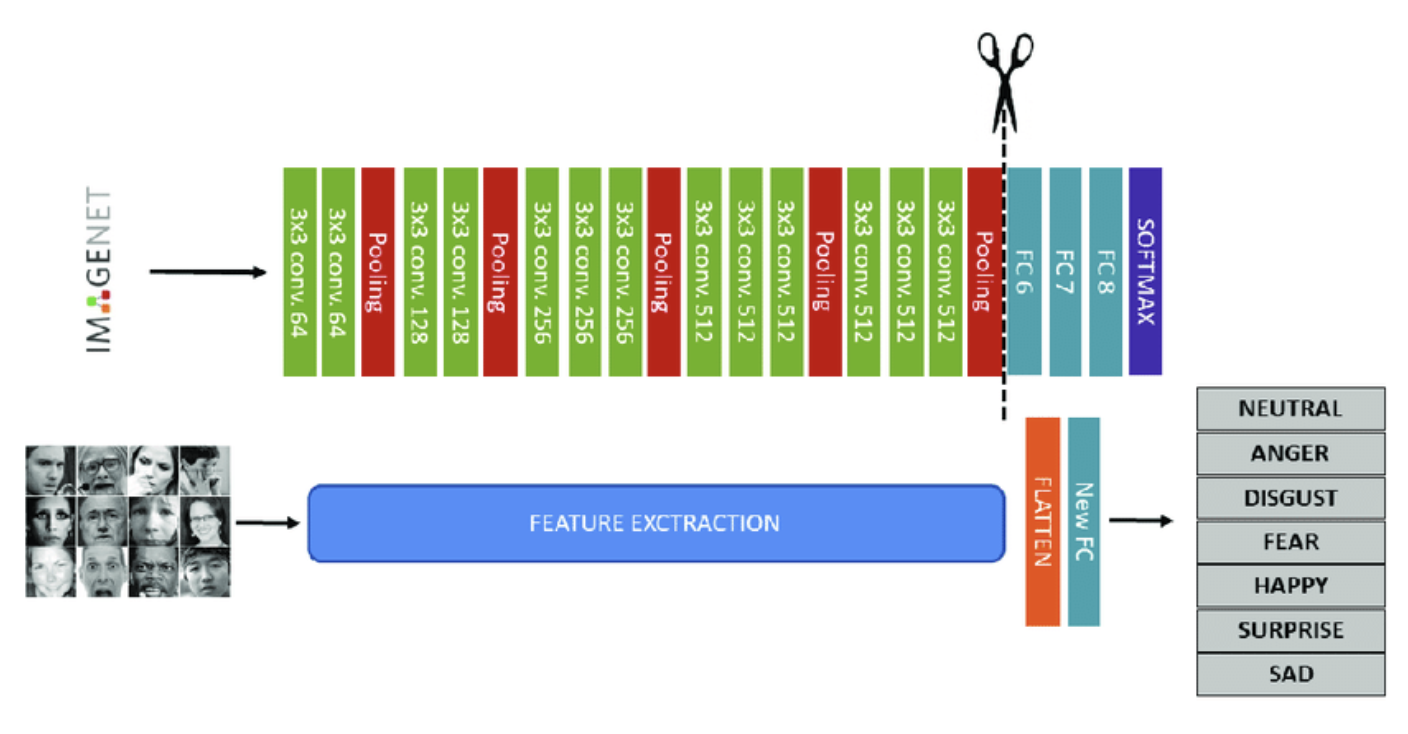

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7 
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),  
    y=classes 
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

tf.keras.backend.clear_session()

vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x) 

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x) 
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=vgg.input, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

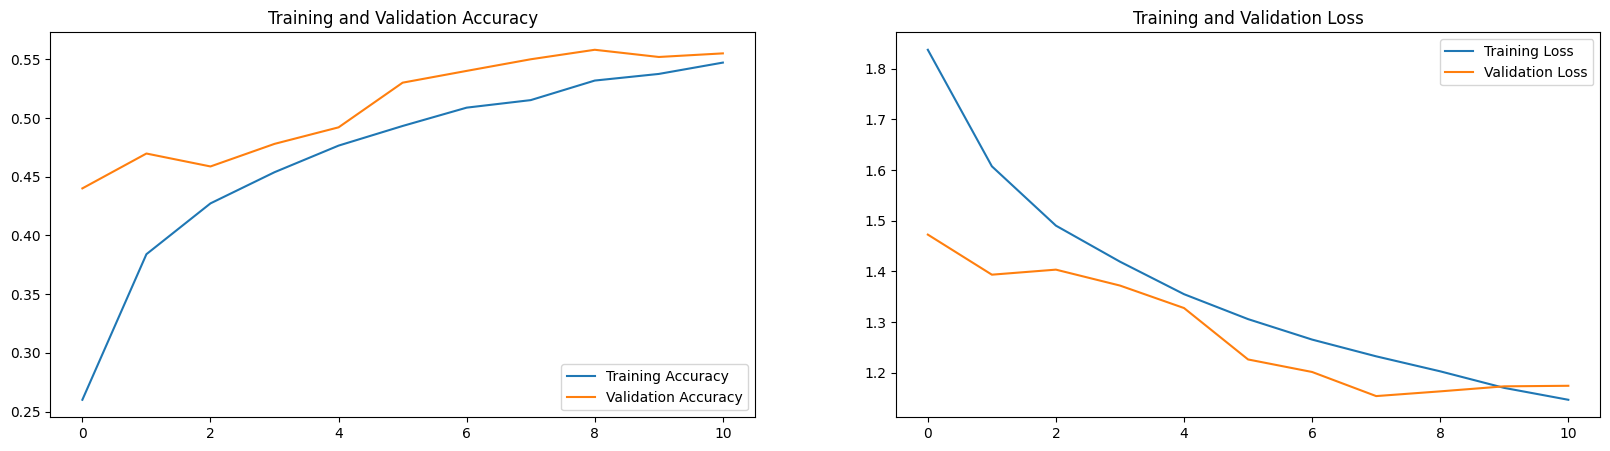

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 29s 257ms/step - loss: 1.1542 - accuracy: 0.5500
final train accuracy = 55.93 , validation accuracy = 55.00


113/113 [==============================] - 28s 250ms/step


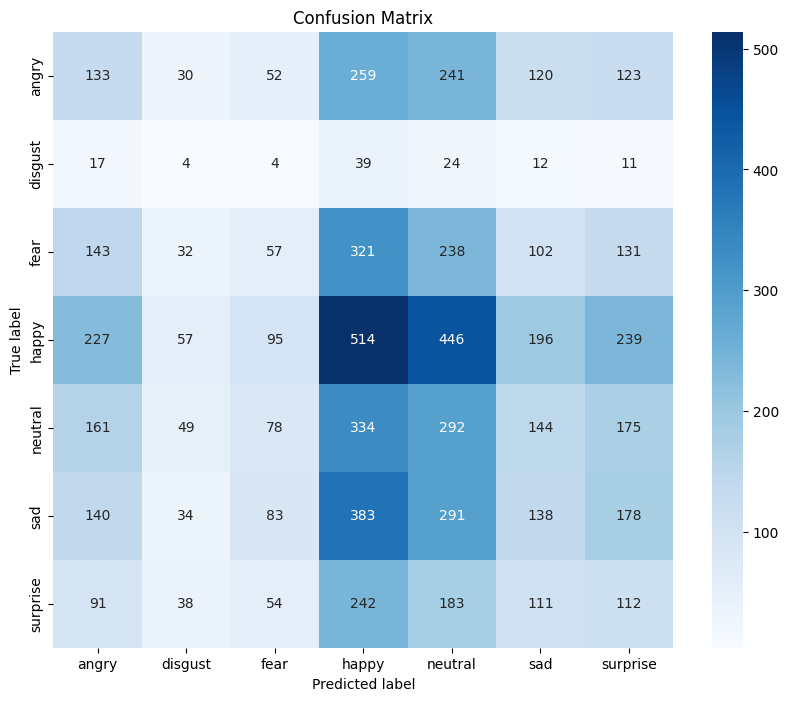

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.14      0.14       958
     disgust       0.02      0.04      0.02       111
        fear       0.13      0.06      0.08      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.17      0.24      0.20      1233
         sad       0.17      0.11      0.13      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178

